In [1]:
# Data Loading

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

In [2]:
# KNN Implementation

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import time

In [7]:
from sklearn.metrics import roc_auc_score

In [3]:
def euclidean(x_test, x_train):
    return np.sqrt(np.sum((x_train - x_test)**2,axis=1))

def manhattan(x_test, x_train):
    return np.sum(np.abs(x_train - x_test), axis=1)

In [4]:
class KNearestNeighbors():

    def __init__(self, x_train, y_train, distance=euclidean, k=5):
        self.x_train = x_train
        self.y_train = y_train
        self.distance = euclidean
        self.k = k

    def predict(self, x_test):
        assignments = []
        for x in x_test:
            distances = self.distance(x, self.x_train)
            nearest_indices = np.argsort(distances)
            neighbors = self.y_train[nearest_indices[:self.k]]
            labels, counts = np.unique(neighbors.flatten(),return_counts=True)
            assignments += [labels[np.argmax(counts)]]
        self.y_pred = np.array(assignments)
        return self.y_pred
    
    def f1(self, y_test):
        recall = self.recall(y_test)
        precision = self.precision(y_test)
        return 2 * recall * precision / (precision + recall).clip(1e-8)

    def recall(self, y_test):
        tp = sum((self.y_pred == 'M') & (self.y_pred == y_test))
        fn = sum((self.y_pred == 'M') & (y_test == 'B'))
        return tp / (tp+fn+(1e-8))
    
    def precision(self, y_test):
        tp = sum((self.y_pred == 'M') & (self.y_pred == y_test))
        fp = sum((self.y_pred == 'B') & (y_test == 'M'))
        return tp / (tp+fp+(1e-8))
    
    def accuracy(self, y_test):
        return sum(self.y_pred == y_test) / len(y_test)
    


In [37]:
# First pass: split 80/20 for train/test

train_set = round(X.shape[0] * 0.8)
x_train = X.values[:train_set]
y_train = y.values[:train_set].flatten()
knn = KNearestNeighbors(x_train,y_train,k=2)

test_set = X.shape[0] - train_set
x_test = X.values[:test_set]
y_test = y.values[:test_set].flatten()

y_pred = knn.predict(x_test)

print(knn.accuracy(y_test), knn.recall(y_test), knn.f1(y_test))

0.9035087719298246 1.0 0.9119999999999999


In [23]:
# AUC curve

roc_auc_score((y_test == 'B'),(y_pred=='B'))

0.9191176470588236

In [24]:
# Compare with Manhattan distance

train_set = round(X.shape[0] * 0.8)
x_train = X.values[:train_set]
y_train = y.values[:train_set].flatten()
knn = KNearestNeighbors(x_train,y_train,k=2,distance=manhattan)

test_set = X.shape[0] - train_set
x_test = X.values[:test_set]
y_test = y.values[:test_set].flatten()

y_pred = knn.predict(x_test)

print(knn.accuracy(y_test), knn.recall(y_test), knn.f1(y_test))

0.9035087719298246 1.0 0.9119999999999999


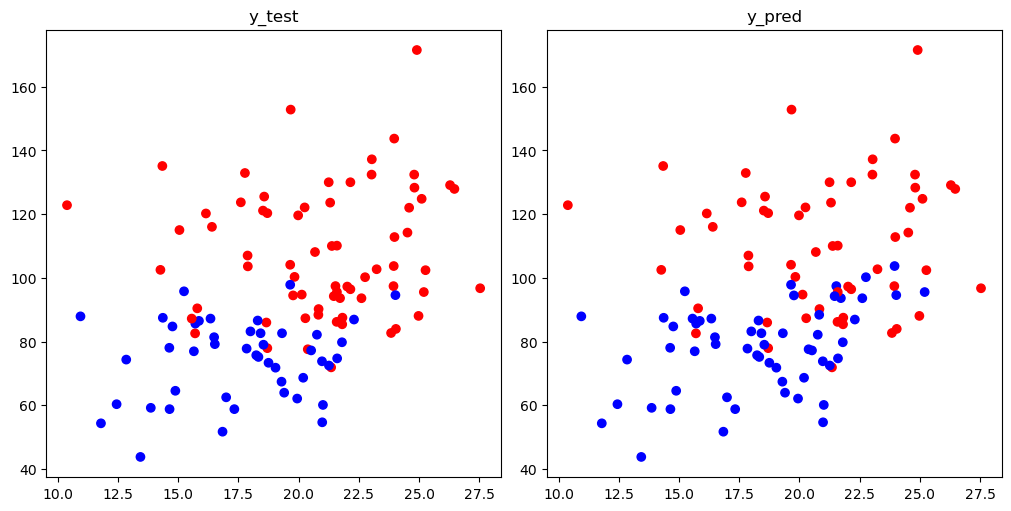

In [25]:
fig, ax = plt.subplots(1,2,layout='constrained',figsize=(10,5))
ax[0].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in y_test])
ax[0].set_title('y_test')
ax[1].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in y_pred])
ax[1].set_title('y_pred')
plt.show()

In [38]:
# Examine different values of k

f1s = []
accuracies = []
recalls = []
preds = []
precisions = []
ks = range(1, 11)
for k in ks:
    knn = KNearestNeighbors(x_train, y_train, k=k)
    preds += [knn.predict(x_test)]
    accuracies += [knn.accuracy(y_test)]
    f1s += [knn.f1(y_test)]
    recalls += [knn.recall(y_test)]
    precisions += [knn.precision(y_test)]

Text(0, 0.5, 'Recall')

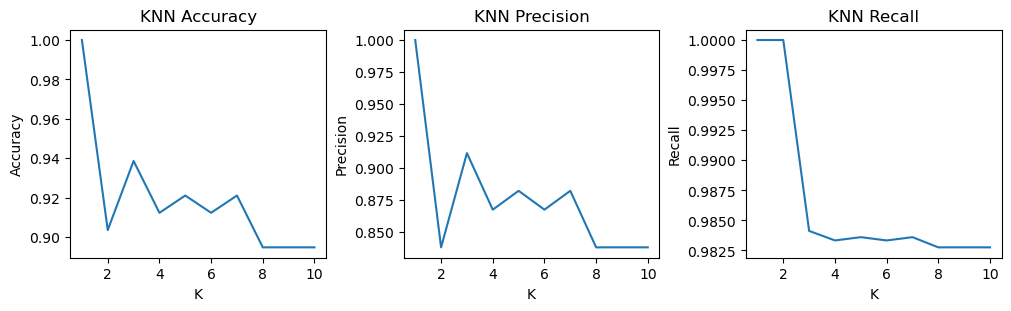

In [40]:
fig,axs = plt.subplots(1,3,layout='constrained',figsize=(10,3))

axs[0].plot(ks, accuracies)
axs[0].set_title('KNN Accuracy')
axs[0].set_xlabel('K')
axs[0].set_ylabel('Accuracy')

axs[1].plot(ks, precisions)
axs[1].set_title('KNN Precision')
axs[1].set_xlabel('K')
axs[1].set_ylabel('Precision')

axs[2].plot(ks, recalls)
axs[2].set_title('KNN Recall')
axs[2].set_xlabel('K')
axs[2].set_ylabel('Recall')

In [8]:
# Examine across k-folds

t = time.process_time()


k_accuracies = []
k_recalls = []
k_precisions = []
k_f1s = []
k_preds = []
k_rocs = []

for k in np.arange(1,11):

    accuracies = []
    recalls = []
    precisions = []
    f1s = []
    preds = []
    rocs = []

    for i in np.arange(5):

        # define folds
        x_train = np.array_split(X.values,5)
        y_train = np.array_split(y.values,5)

        x_test, y_test = x_train.pop(i), y_train.pop(i).flatten()
        x_train, y_train = np.concatenate(x_train), np.concatenate(y_train)

        # run algorithm and eval
        knn = KNearestNeighbors(x_train, y_train, k=k)
        preds += [knn.predict(x_test)]
        accuracies.append(knn.accuracy(y_test))
        precisions.append(knn.precision(y_test))
        recalls.append(knn.recall(y_test))
        f1s.append(knn.f1(y_test))
        rocs += [roc_auc_score((y_test == 'B'),(preds[i]=='B'))]

    k_accuracies += [accuracies]
    k_recalls += [recalls]
    k_precisions += [precisions]
    k_f1s += [f1s]
    k_preds += [preds]
    k_rocs += [rocs]

In [9]:
mean_accuracy=[]
mean_recall=[]
mean_precision=[]
mean_f1=[]

std_accuracy=[]
std_recall=[]
std_precision=[]
std_f1=[]

for i in np.arange(10):

    mean_accuracy.append(np.mean(k_accuracies[i]))
    mean_recall.append(np.mean(k_recalls[i]))
    mean_precision.append(np.mean(k_precisions[i]))
    mean_f1.append(np.mean(k_f1s[i]))

    std_accuracy.append(np.std(k_accuracies[i]))
    std_recall.append(np.std(k_recalls[i]))
    std_precision.append(np.std(k_precisions[i]))
    std_f1.append(np.std(k_f1s[i]))

In [10]:
# Manhattan version

# Examine across k-folds

t = time.process_time()


k_accuracies_m = []
k_recalls_m = []
k_precisions_m = []
k_f1s_m = []
k_preds_m = []
k_rocs_m = []

for k in np.arange(1,11):

    accuracies = []
    recalls = []
    precisions = []
    f1s = []
    preds = []
    rocs = []

    for i in np.arange(5):

        # define folds
        x_train = np.array_split(X.values,5)
        y_train = np.array_split(y.values,5)

        x_test, y_test = x_train.pop(i), y_train.pop(i).flatten()
        x_train, y_train = np.concatenate(x_train), np.concatenate(y_train)

        # run algorithm and eval
        knn = KNearestNeighbors(x_train, y_train, k=k, distance=manhattan)
        preds += [knn.predict(x_test)]
        accuracies.append(knn.accuracy(y_test))
        precisions.append(knn.precision(y_test))
        recalls.append(knn.recall(y_test))
        f1s.append(knn.f1(y_test))
        rocs += [roc_auc_score((y_test == 'B'),(preds[i]=='B'))]

    k_accuracies_m += [accuracies]
    k_recalls_m += [recalls]
    k_precisions_m += [precisions]
    k_f1s_m += [f1s]
    k_preds_m += [preds]
    k_rocs_m += [rocs]

In [12]:
mean_accuracy_m=[]
mean_recall_m=[]
mean_precision_m=[]
mean_f1_m=[]

for i in np.arange(10):

    mean_accuracy_m.append(np.mean(k_accuracies_m[i]))
    mean_recall_m.append(np.mean(k_recalls_m[i]))
    mean_precision_m.append(np.mean(k_precisions_m[i]))
    mean_f1_m.append(np.mean(k_f1s_m[i]))

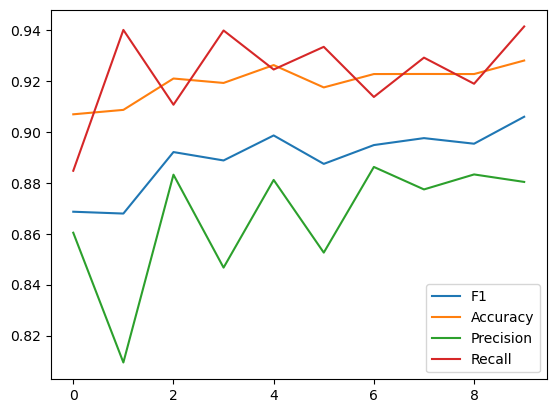

In [13]:
plt.plot(mean_f1,label='F1')
plt.plot(mean_accuracy,label='Accuracy')
plt.plot(mean_precision,label='Precision')
plt.plot(mean_recall,label='Recall')
plt.legend()

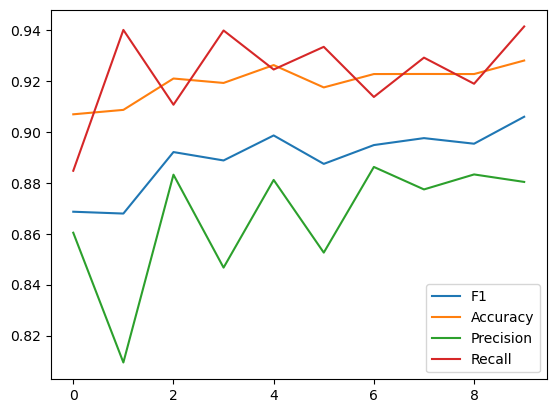

In [14]:
plt.plot(mean_f1_m,label='F1')
plt.plot(mean_accuracy_m,label='Accuracy')
plt.plot(mean_precision_m,label='Precision')
plt.plot(mean_recall_m,label='Recall')
plt.legend()

Text(0.5, 1.0, 'Average performance across Folds for K=1...10 Neighbors')

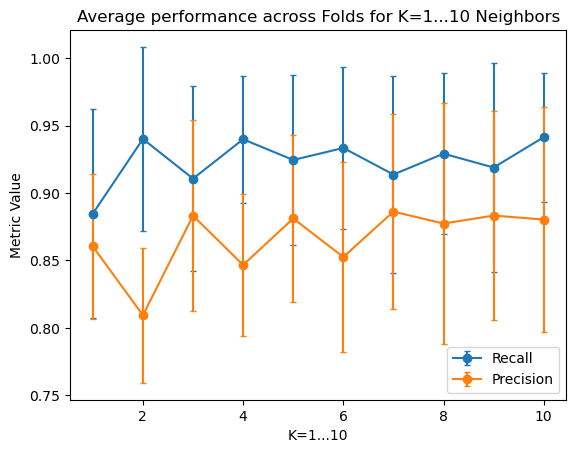

In [96]:
x = np.arange(1,11)
plt.errorbar(x, mean_recall,yerr=std_recall,label='Recall',fmt='-o',capsize=2)
plt.errorbar(x, mean_precision,yerr=std_precision,label='Precision',fmt='-o',capsize=2)
#plt.errorbar(x, mean_f1,yerr=std_f1,label='F1',fmt='-o',capsize=2)

plt.legend()
plt.ylabel('Metric Value')
plt.xlabel('K=1...10')
#plt.ylim(0.77,1)

plt.title('Average performance across Folds for K=1...10 Neighbors')

In [30]:
print(np.average(accuracies),np.average(recalls),np.average(f1s),np.average(rocs))
print(np.std(accuracies),np.std(recalls),np.std(f1s),np.std(rocs))

0.9209284272628473 0.9106403236837803 0.8920527147878244 0.9201570528936888
0.039202267035206975 0.06857385389922359 0.032653525051117606 0.030466753428407458


Text(0.5, 1.0, 'Metrics across Folds')

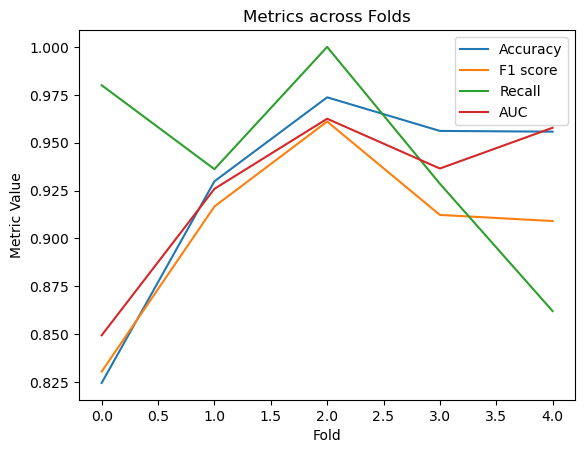

In [99]:
plt.plot(accuracies,label='Accuracy')
plt.plot(f1s,label='F1 score')
plt.plot(recalls,label='Recall')
plt.plot(rocs,label='AUC')
plt.legend()
plt.ylabel('Metric Value')
plt.xlabel('Fold')
plt.title('Metrics across Folds')

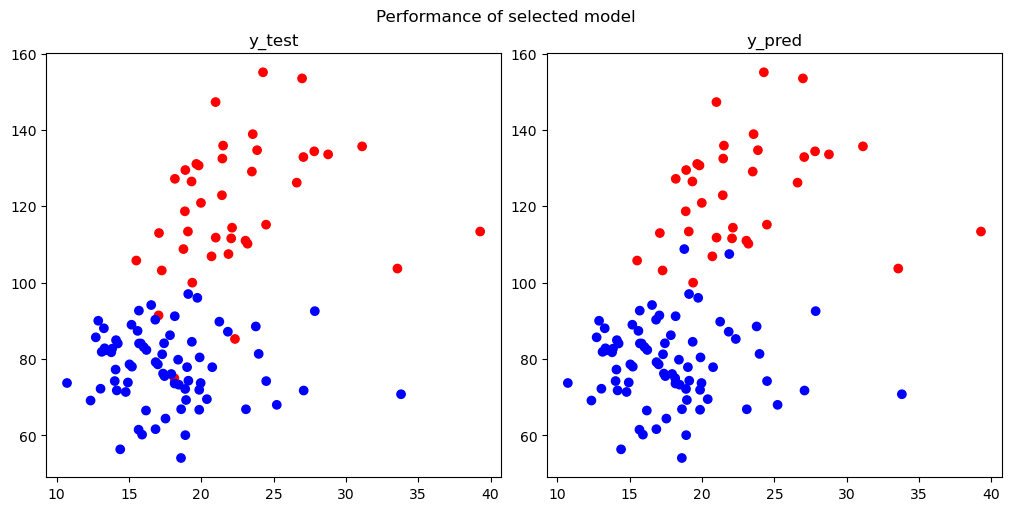

In [13]:
x_train = np.array_split(X.values,5)
y_train = np.array_split(y.values,5)
x_test, y_test = x_train.pop(2), y_train.pop(2).flatten()
x_train, y_train = np.concatenate(x_train), np.concatenate(y_train)

fig, ax = plt.subplots(1,2,layout='constrained',figsize=(10,5))
ax[0].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in y_test])
ax[0].set_title('y_test')
ax[1].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in preds[2]])
ax[1].set_title('y_pred')
fig.suptitle('Performance of selected model')
plt.show()